In [1]:
# importing things
from astropy.io import ascii, fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from photutils.background import MMMBackground, Background2D, MedianBackground, SExtractorBackground
from astropy.table import Table
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import (ZScaleInterval, LinearStretch,
                                   ImageNormalize, MinMaxInterval, PowerStretch)
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.segmentation import detect_threshold, detect_sources, SourceCatalog, deblend_sources
import pandas as pd

In [2]:
def read_data(file_path):
    '''
    Reading a .fits file
    '''
    hdu = fits.open(file_path, menmap=True)
    data = hdu[1].data
    header = hdu[1].header
    wcs = WCS(header)
    return data, header, wcs


def remove_at_edges(x, y, data, r_in=3, r_out=5):
    '''
    Remove sources that are close to the edges of the image.
    There are probably much smarter ways to do this.
    '''
    mask_edge = np.ones(len(x))
    for i in range(len(x)):
        aperture = CircularAnnulus((x[i], y[i]), r_in=r_in, r_out=r_out)
        mask = aperture.to_mask(method='center')
        masked_data = mask.multiply(data)
        if np.isnan(np.sum(masked_data)):
            mask_edge[i] = 0
    return mask_edge.astype('bool')


def detect_seg(data, fwhm=3, npixels=3, wcs=None, threshold=3):
    '''
    Use photutils segmentation routines to detect sources.
    Use on background subtracted data!!
    '''
    sigma = fwhm * gaussian_fwhm_to_sigma  # FWHM = 3.
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    # in Adamo 2020: use 3 npixels
    segm = detect_sources(data, threshold, npixels=npixels,
                          kernel=kernel)
    segm_deblend = deblend_sources(data, segm, npixels=npixels,
                                   kernel=kernel, nlevels=32,
                                   contrast=0.001)
    # convert to a table
    cat = SourceCatalog(data, segm_deblend, kernel=kernel, wcs=wcs)
    tab = Table(cat.to_table())
    mask = remove_at_edges(tab['xcentroid'], tab['ycentroid'], data)
    return tab[mask]


def subtract_background(data, estimator='Median'):
    '''
    Locally determine the background and subtract from the data (medianfiltering it)
    '''
    if estimator == 'Median':
        bkg_estimator = MedianBackground()
    else:
        bkg_estimator = SExtractorBackground()
    sigma_clip = SigmaClip(sigma=3.)
    bkg = Background2D(data, (7, 7), filter_size=(5, 5),
                       bkg_estimator=bkg_estimator, sigma_clip=sigma_clip)
    # subtract the background
    data_sub = data - bkg.background
    data_sub[np.isnan(data)] = np.nan
    data_sub[data == 0] = np.nan
    return data_sub, bkg.background_rms

def match_catalogues(cat1, cat2, x1='x', y1='x', x2='xcentroid', y2='ycentroid', r_lim=2):
    """
    Match two catalogues, returns the mask arrays for both catalogues
    """
    indexes=[]
    matched1 = np.zeros(len(cat1), dtype='bool')
    matched_idx = np.full_like(cat1[x1], np.nan)
    matched2 = np.zeros(len(cat2), dtype='bool')
    matched_idx2 = np.full_like(cat2[x2], np.nan)
    for i in range(len(cat1)):
        rs = np.sqrt((cat2[x2] - cat1[x1][i])**2 + (cat2[y2] - cat1[y1][i])**2)
        rmin = np.nanmin(rs)
        if rmin < r_lim:
            idx = np.where(rs == rmin)
            if idx[0][0] in indexes:
                #print('This source was already matched!')
                matched1[i] = False
            else:
                matched1[i] = True
                indexes.append(idx[0][0])
                matched_idx[i] = idx[0][0]
                matched_idx2[idx[0][0]] = i
                matched2[idx[0][0]] = True
    return matched1, matched2, matched_idx, matched_idx2
                
def do_aperture_photometry(data, x, y, rads=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], r_in=10,
                            r_out=15, second_indx=2, zpt=0, A=0):
    '''
    Aperture photometry around a source with different radii
    '''
    positions = [(x), (y)]
    # Annulus for background determination with inner radius r_in, outer radius r_out
    annulus_aperture = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    annulus_masks = annulus_aperture.to_mask(method='center')
    mask = annulus_masks
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    bkg_median, std = sigma_clipped_stats(annulus_data_1d, sigma=2.0)[1:]
    fluxes, mags = np.zeros(len(rads)), np.zeros(len(rads))
    for i in range(len(rads)):
        aperture = CircularAperture(positions, r=rads[i])
        phot = aperture_photometry(data, aperture)
        phot['aper_bkg'] = bkg_median * aperture.area
        fluxes[i] = phot['aperture_sum'] - phot['aper_bkg']
        mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
    return mags

In [5]:
# read the HST data in both filters
galaxy = 'FCC47'

data_dir = 'PATH_TO_THE_DATA'
file_g = data_dir + '{0}_F475W.fits'.format(galaxy)
file_z = data_dir + '{0}_F850LP.fits'.format(galaxy)

#read the data
data_g, header_g, wcs_g = read_data(file_g)
data_z, header_z, wcs_z = read_data(file_z)

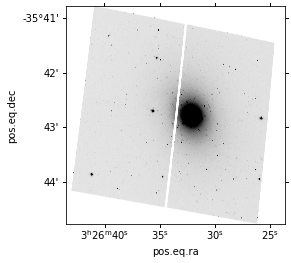

In [6]:
#plot the galaxy
fig, ax = plt.subplots(subplot_kw={'projection':wcs_g})
norm = ImageNormalize(data_g,interval=ZScaleInterval(), stretch=LinearStretch())
ax.imshow(data_g, origin='lower', norm=norm, cmap='Greys')

In [7]:
# remove galaxy background
data_g, background_rms_g = subtract_background(data_g, estimator='Median')
data_z, background_rms_z = subtract_background(data_z, estimator='Median')

## Source Detection

In [8]:
fwhm = 3 #pixel
threshold_g = 2*background_rms_g
threshold_z = 2*background_rms_z

tab_g = detect_seg(data_g, fwhm=fwhm, threshold=threshold_g, wcs=wcs_g, npixels=2)
tab_z = detect_seg(data_z, fwhm=fwhm, threshold=threshold_z, wcs=wcs_z, npixels=2)
print('{0} sources found in F475W!'.format(len(tab_g)))
print('{0} sources found in F850LP!'.format(len(tab_z)))

8153 sources found in F475W!
7882 sources found in F850LP!


In [9]:
#only those that are in both catalogues
matched_g, matched_z = match_catalogues(tab_g, tab_z, x1='xcentroid', y1='ycentroid', x2='xcentroid', y2='ycentroid', r_lim=2)[0:2]
print('{0} matched sources!'.format(len(tab_g[matched_g])))

947 matched sources!


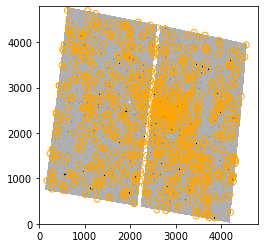

In [10]:
#plot sources on image
fig, ax = plt.subplots()
norm = ImageNormalize(data_g,interval=ZScaleInterval(), stretch=LinearStretch())
ax.imshow(data_g, origin='lower', norm=norm, cmap='Greys')
ax.scatter(tab_g['xcentroid'][matched_g], tab_g['ycentroid'][matched_g], marker='o', facecolor='None', edgecolor='orange')

In [11]:
tab_g = tab_g[matched_g]
tab_z = tab_z[matched_z]
#to convert skycoord in ra and dec
tab_g = Table.from_pandas(tab_g.to_pandas())
tab_z = Table.from_pandas(tab_z.to_pandas())
    

In [12]:
#remove not needed columns
tab_g.remove_columns(['bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax', 'local_background', 'segment_fluxerr', 'kron_fluxerr'])
tab_z.remove_columns(['bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax', 'local_background', 'segment_fluxerr', 'kron_fluxerr'])

In [13]:
#combine tab_g and tab_z

import copy

tab = copy.deepcopy(tab_g)

#galaxy and ID column
tab.add_column(np.full(len(tab), galaxy), name='galaxy', index=0)
tab.add_column(np.arange(len(tab)), name='ID', index=0)

r_lim = 2
#rename columns in tab_z to later put in tab
for name in tab_z.colnames:
    tab['{0}_z'.format(name)] = np.full_like(tab_z[name], np.nan)
#loop through tab and match sources again. Probably could use idx from matching above
for i in range(len(tab)):
    rs = np.sqrt((tab_z['xcentroid'] - tab_g['xcentroid'][i])**2 + (tab_z['ycentroid'] - tab_g['ycentroid'][i])**2)
    rmin = np.nanmin(rs)
    if rmin < r_lim:
        maski = rs < r_lim
        if len(rs[maski]) > 1:
            print('Found {0} matches! Not good!'.format(len(rs[maski])))
        idx = np.where(rs == rmin)
        for name in tab_z.colnames:
            colname_i = name + '_z'
            tab[colname_i][i] = tab_z[name][idx]

## Basic aperture photometry

In [14]:
#zero points and extinction
zpt_g = 26.068
zpt_z = 24.871

eB_V = 0.012
Ag = 3.634*eB_V
Az = 1.485*eB_V

In [15]:
#doing aperture photometry, here only for 3 pixel aperture
#might put out some warnings about logarithms etc
tab['CI3_g'] = np.zeros(len(tab))
tab['CI3_z'] = np.zeros(len(tab))
tab['m3_g'] = np.zeros(len(tab))
tab['m3_z'] = np.zeros(len(tab))
for i in range(len(tab)):
    mags_g = do_aperture_photometry(
            data_g, tab['xcentroid'][i], tab['ycentroid'][i], zpt=zpt_g, A=Ag)
    mags_z = do_aperture_photometry(
            data_z, tab['xcentroid_z'][i], tab['ycentroid_z'][i], zpt=zpt_z, A=Az)
    tab['m3_g'][i], tab['CI3_g'][i] = mags_g[2], mags_g[0] - mags_g[2]
    tab['m3_z'][i], tab['CI3_z'][i] = mags_z[2], mags_z[0] - mags_z[2]

tab['colour'] = tab['m3_g'] - tab['m3_z']
        

<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid va

<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid value encountered in log10
  mags[i] = -2.5*np.log10(fluxes[i]) + zpt - A
<ipython-input-2-c4781aa7bfa7>:109: RuntimeWarning: invalid va

In [16]:
#write the table
tab.write('{0}_sources.csv'.format(galaxy), format='pandas.csv')